full install instructions in readme. in brief, after making an environment, run the following:

In [ ]:
!git clone https://github.com/mouseland/critical_init.git
!cd critical_init
!pip install -r requirements.txt

### example simulation of dynamics with random symmetric connectivity matrix

In [1]:
import numpy as np
import torch 
from tqdm import trange
from powerlaw import fit_powerlaw_exp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
nn = 10000 # number of neurons
T = 60000 # number of timesteps
nd = 200 # number of random initial conditions
tpad = 4000 # number of initial timepoints to exclude (to exclude transient dynamics)
dt = 2 # time step in milliseconds
tau = 50 # neuron time constant
tbin = 23 # time binning

torch.manual_seed(10)
if device.type == "cuda":
    torch.cuda.manual_seed(10)

# uniform random connectivity matrix
A = 2 * torch.rand((nn, nn), device=device) - 1
# symmetrize
A -= torch.triu(A)
A = A + A.T
A -= torch.diag(torch.diag(A))

# compute eigenvalues
evals0, evecs0 = torch.linalg.eigh(A)
# normalize matrix so eigenvalues are less than 1
enorm = evals0.real.max() / 0.999
evals0 /= enorm
A /= enorm       

# simulate dynamics
X = torch.randn((nn, nd), device=device) 
Xi = torch.zeros((nn, nd, (T-tpad)//tbin), device=device)
for t in trange(T):
    eps = torch.randn((nn, nd), device=device)
    X += dt / tau * (-X + A @ X + eps)
    if t >= tpad and (t-tpad)//tbin < Xi.shape[-1]:
        Xi[:, :, (t-tpad)//tbin] += X
Xi /= tbin
Xi = Xi.reshape(nn, -1)

# zscore
X_mean = Xi.mean(axis=1, keepdim=True)
Xi -= X_mean
Xi /= Xi.std(axis=1, keepdim=True)

# compute covariance matrix and eigenvalues
cov = Xi @ Xi.T / nd
evals, evecs = torch.linalg.eigh(cov)
evals = evals.cpu().numpy()[::-1]

alpha, yp = fit_powerlaw_exp(evals, np.arange(10, 500))
print(fr"alpha = {alpha:.3f}")


100%|██████████| 60000/60000 [03:32<00:00, 282.76it/s]


alpha = 0.684


Text(0, 0.5, 'normalized variance')

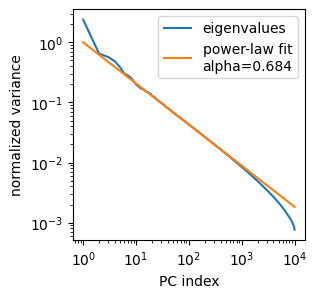

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3,3))
plt.loglog(np.arange(1, nn+1), evals / yp[0], label="eigenvalues")
plt.loglog(np.arange(1, nn+1), yp / yp[0], label=f"power-law fit\nalpha={alpha:.3f}")
plt.legend(loc="upper right")
plt.xlabel("PC index")
plt.ylabel("normalized variance")

### visualize activity

In [5]:
from rastermap import Rastermap
Xt = Xi.cpu().numpy().copy()
model = Rastermap(mean_time=False, bin_size=25, 
                time_lag_window=0, locality=0.).fit(Xt[:, :50000])
Xex = model.X_embedding

2025-02-27 18:51:58,352 [INFO] normalizing data across axis=1
2025-02-27 18:52:00,405 [INFO] data normalized, 2.05sec
2025-02-27 18:52:00,407 [INFO] sorting activity: 10000 valid samples by 50000 timepoints
2025-02-27 18:52:06,184 [INFO] n_PCs = 200 computed, 7.83sec
2025-02-27 18:52:07,468 [INFO] 67 clusters computed, time 9.12sec
2025-02-27 18:52:08,442 [INFO] clusters sorted, time 10.09sec
2025-02-27 18:52:08,542 [INFO] clusters upsampled, time 10.19sec
2025-02-27 18:52:09,458 [INFO] rastermap complete, time 11.11sec


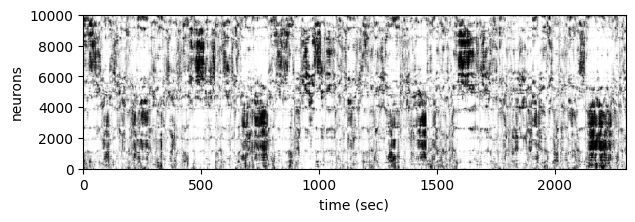

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 2))
plt.imshow(Xex, aspect="auto", cmap="gray_r", vmin=0, vmax=1.5, 
           extent=[0, Xex.shape[1] * (dt * tbin) / 1000, 0, nn])
plt.xlabel("time (sec)")
plt.ylabel("neurons");